# Lab6 DBSCAN

This week's exercise will focus on density-based clustering using DBSCAN

Schedule:
* Implement the core of DBSCAN
* Clustering visualizations

In [1]:
# ! git pull

In [2]:
# Makes matplotlib plots work better with Jupyter
%matplotlib inline

# Import the necessary libraries. 
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans, DBSCAN
from collections import deque

pd.options.mode.chained_assignment = None

## Take a look at the data

In [3]:
# generate 2d moons dataset
X, _ = make_moons(n_samples=100, noise=0.1)
data = pd.DataFrame(dict(x0=X[:,0], x1=X[:,1]))

features = ['x0', 'x1']

print(data.columns)

Index(['x0', 'x1'], dtype='object')


In [4]:
# Standardize features
data[features] = data[features].sub(data[features].mean(axis=0)).divide(data[features].std(axis=0))

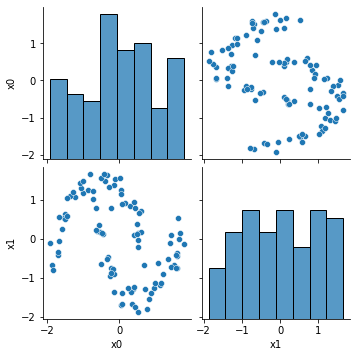

In [5]:
sns.pairplot(data, vars=features)

The scatter plot gives us a visual overview of the possible clusters. Let's see what happens when we try to partition the data with K-means (implemented in `sklearn.clusters`). Let's set K to 2.

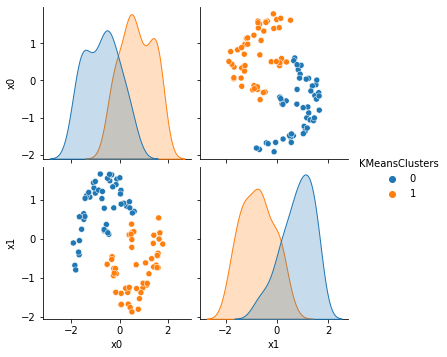

In [6]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(data[features])
data['KMeansClusters'] = pd.Series(kmeans.labels_)

sns.pairplot(data, vars=features, hue='KMeansClusters')

We can see that *K-Means* is not an appropriate clustering algorithm for this kind of dataset. Let's try to use **DBSCAN**, a density-based algorithm, and see if we can achieve better results.

**Spoiler: We will**

In [7]:
# You might want to play around with the parameters "epsilon" and "min_samples" and see which results you can get
DBSCANClustering = DBSCAN(eps=0.4, min_samples=4).fit(data[features])
data['DBSCANClusters'] = pd.Series(DBSCANClustering.labels_)

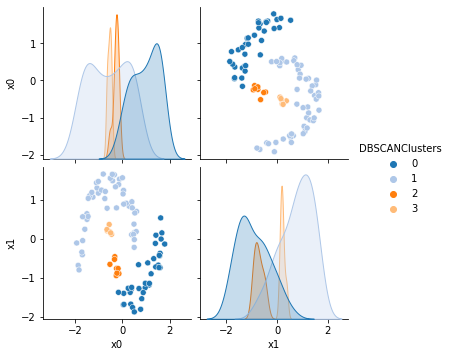

In [8]:
clusterNames = data['DBSCANClusters'].unique()
clusterNames.sort()

n_clusters = len(clusterNames)

# Use circles for clusters ("o") and crosses for outliers ("x")
markers = ["o"] * (n_clusters)
if clusterNames[0] == -1:
    markers[0] = "X"

sns.pairplot(data, vars=features, hue='DBSCANClusters', palette=sns.color_palette("tab20", n_clusters), markers=markers)

In [9]:
# Let's go back to the original dataset:
data = data.drop('KMeansClusters', axis=1)
data = data.drop('DBSCANClusters', axis=1)
data.head()

,x0,x1
0,1.137215,-1.180232
1,0.379682,-1.292254
2,1.525360,-0.670382
3,-1.858671,-0.677999
4,-1.005677,1.167132


# DBSCAN - TODOTODOTODOTODOTODOTODOTODOTODOTODOTODOTODOTODO
[DBSCAN Algorithm](https://towardsdatascience.com/dbscan-algorithm-complete-guide-and-application-with-python-scikit-learn-d690cbae4c5d)
1. Initialize the *visited* set and the *toVisitQueue*
2. create K random centroids as arrays with size the number of features
3. foreach `datapoint` in `data`:
  1. set as `centroid` of `datapoint` the closest `centroid`
  2. if at least one `centroid` has changed: goto 3
  
### Tips
- the computations needed for k-means are expensive, test on a small subset of the data to save time (5/10 to check calculations on single rows, 50/100 to check the correctness of the whole algorithm)
- you'll need to compute a distance at a certain point, check Lab3
- [DataFrame.idxmin](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.idxmin.html]) will give you the index of the smallest entry in a dataset
- `dataFrame1 is dataFrame2` is not correct (it checks if the two objects are the same, not if they contain the same values). The correct approach is `dataFrame1.equals(dataFrame2)` (or `dataFrame1['aColumn'].equals(dataFrame2['aColumn'])` ;))
- You can apply a function to every element/row/column of a dataframe by using the `apply` pandas function
- To update the values of the centroids, you might find the combination of `groupby` and `mean` to be useful.
### Visualizing DBSCAN Algorithm [(link)](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)
Naftali Harris has created a great web-based visualization of running DBSCAN on a 2-dimensional dataset. Try clicking on the “Smiley” dataset and hitting the GO button.

In [14]:
def DBSCAN(data, epsilon=0.25, min_samples=3):
    
    # 1a - Set of the indices of points that have been already visited
    visited = set()
    
    # 1c - Initialize every point as an outlier (Cluster = -1)
    data = data.assign(Cluster=pd.Series([-1] * len(data)))
    
    currentCluster = 0
    
    def neighbourhood(x):
        # Find the distance between x and every point in the dataset
        distances = data[features].sub(x[features]) \
            .pow(2).sum(1).pow(0.5)
        # Return the list of indices of the points that are at distance <= epsilon
        ## YOUR CODE HERE
        return distances.loc[(distances <= epsilon)].index.tolist()
    
    # This function starts a cluster formation. 
    # If the starting point is a core point, add its non-visited neighbours to the queue 
    # If the starting point is not a core point, the cluster formation stops and False is returned
    def cluster_formation(startIndex):
        visited.add(startIndex)
        aClusterHasBeenFormed = False
        
        # Queue of the indices of points that are in the neighbourhood of a core point, but that have not been visited yet
        pointsToAddToCurrentCluster = deque()
        pointsToAddToCurrentCluster.append(startIndex)
        
        # Start the cluster formation: While the queue is not empty...
        while len(pointsToAddToCurrentCluster) > 0:
            # ... Pop from the queue to get the current point
            currentIndex = pointsToAddToCurrentCluster.popleft()
            
            # Get the neighbours of the current point
            ## YOUR CODE HERE
            neighbours = neighbourhood(data.loc[currentIndex])
            
            # If the current point is a core point...
            ## YOUR CODE HERE
            if(len(neighbours) >= min_samples):
                aClusterHasBeenFormed = True
                
                # Assign the current point and its neighbours to the current cluster
                ## YOUR CODE HERE
                data.at[currentIndex, 'Cluster'] = currentCluster
                data.at[neighbours, 'Cluster'] = currentCluster
                
                # Add the non-visited neighbours to the queue of points to visit
                ## YOUR CODE HERE
                for neighbourIndex in neighbours:
                    if not neighbourIndex in visited:
                        visited.add(neighbourIndex)
                        pointsToAddToCurrentCluster.append(neighbourIndex)
        return aClusterHasBeenFormed
    
    # For each unvisited point in the dataset, start a cluster formation
    for rowIndex in data.index:
        if rowIndex in visited:
            continue
            
        aClusterHasBeenFormed = cluster_formation(rowIndex)
        
        # if a cluster has been formed (= if the current row is not an outlier),
        # increase the currentCluster number for the next iterations
        if aClusterHasBeenFormed:
            currentCluster += 1
    
    return data

In [15]:
new_data = DBSCAN(data, epsilon=0.4, min_samples=4)

In [16]:
new_data

,x0,x1,Cluster
0,1.137215,-1.180232,0
1,0.379682,-1.292254,0
2,1.525360,-0.670382,0
3,-1.858671,-0.677999,1
4,-1.005677,1.167132,1
...,...,...,...
95,0.512407,-1.865809,0
96,-1.434753,1.032427,1
97,0.511306,-0.019217,1
98,0.887717,-1.372031,0


# Clusters visualization
The most difficult task with clustering is understand if the clustering makes sense and what the clustering means. If the dimensionality is low, a good idea is to use a pairplot and see if the clusters are really close in each slice. The closer they are, the better.

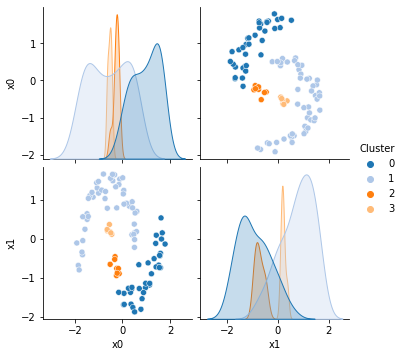

In [17]:
clusterNames = new_data['Cluster'].unique()
clusterNames.sort()
n_clusters = len(clusterNames)

markers = ["o"] * (n_clusters)
if clusterNames[0] == -1:
    markers[0] = "X"

sns.pairplot(new_data, vars=features, hue='Cluster', palette=sns.color_palette("tab20", n_clusters), markers=markers)